In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import benchmark.models.retriever_loader as model_loader
import benchmark.datasets as datasets

# Intra-GA Recommendation

In [ ]:
print("🔧 Setting up Intra-GA environment...")
class IntraArgs:
    dataset_json_dir = './SciGA-for-experiments/json/'
    dataset_figure_dir = './SciGA-for-experiments/figures/'
    model_type = 'CLIP'
    ckpt_path = './benchmark/output/checkpoints/intra_with_abs2fig/CLIP_intra_with_abs2fig_cap.pt'
    model_name = None
    model_config_path = None
    device = 0
    batch_size = 8
    num_workers = 2
    is_merge_caption = True

args = IntraArgs()
device = torch.device(f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu')
print(f'✅ Using device: {device}')

🔧 Setting up Intra-GA environment...
✅ Using device: cuda:0


In [86]:
print("🔄 Loading datasets...")
test_split = datasets.load_and_prepare_split(
    split_name='test',
    dataset_json_dir=args.dataset_json_dir,
    dataset_figure_dir=args.dataset_figure_dir,
)

print("🔄 Loading model...")
model = model_loader.load_abs2fig_retriever_for_intra_GA_recommendation(
    model_type=args.model_type,
    model_name=args.model_name,
    ckpt_path=args.ckpt_path,
    model_config_path=args.model_config_path,
).to(device)
model.eval()

print("✅ Successfully")

🔄 Loading datasets...
🔄 Loading model...

✅ Successfully


In [110]:
print("🔄 Loading dataset...")
sampled = test_split.sample(1).iloc[0]
sampled_paper_id = sampled['paper_id']
sampled_research_fields = sampled['research_fields']
sampled_abstract = sampled['abstract']
sampled_GT_figure_ids = sampled['GT_figure_ids']
sampled_figure_paths = sampled['figure_paths']
sampled_figure_captions = sampled['figure_captions']
sampled_GA_path = sampled['GA_path']
sampled_GA_caption = sampled['GA_caption']
dataset = datasets.Abs2FigRetrieverDatasetForIntraGARecommendation(
    paper_id=[sampled_paper_id],
    research_fields=[sampled_research_fields],
    abstract=[sampled_abstract],
    GA_path=[sampled_GA_path],
    GA_caption=[sampled_GA_caption],
    figure_paths=[sampled_figure_paths],
    figure_captions=[sampled_figure_captions],
    tokenizer=model.tokenize,
    transform=model.preprocess_image,
    GT_figure_ids=[sampled_GT_figure_ids],
)

print("🔄 Loading dataloader")
loader = DataLoader(
    dataset,
    batch_size=args.batch_size,
    collate_fn=dataset.collate_fn,
    shuffle=False,
    num_workers=args.num_workers,
)

print("✅ Successfully")

🔄 Loading dataset...
🔄 Loading dataloader
✅ Successfully


📝 Query Paper Info
   - ID: arXiv.2209.10020
   - Research Fields: ['cs.CV']
   - Abstract: Growing free online 3D shapes collections dictated research on 3D retrieval. Active debate has however been had on (i) what the best input modality is to trigger retrieval, and (ii) the ultimate usage scenario for such retrieval. In this paper, we offer a different perspective towards answering these questions – we study the use of 3D sketches as an input modality and advocate a VR-scenario where retrieval is conducted. Thus, the ultimate vision is that users can freely retrieve a 3D model by air-doodling in a VR environment. As a first stab at this new 3D VR-sketch to 3D shape retrieval problem, we make four contributions. First, we code a VR utility to collect 3D VR-sketches and conduct retrieval. Second, we collect the first set of <MATH> 167 </MATH> 3D VR-sketches on two shape categories from ModelNet. Third, we propose a novel approach to generate a synthetic dataset of human-like 3D sketch

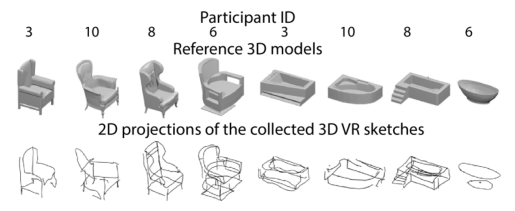

   - Caption: Our collected VR sketches exhibit variability of sketching styles and levels of details.



In [111]:
print("📝 Query Paper Info")
print(f"   - ID: arXiv.{sampled_paper_id}")
print(f"   - Research Fields: {sampled_research_fields}")
print(f"   - Abstract: {sampled_abstract}")

img = mpimg.imread(sampled_GA_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"   - Caption: {sampled_GA_caption}\n")


Top-5 Intra-GA Figures for Query: arXiv.2209.10020


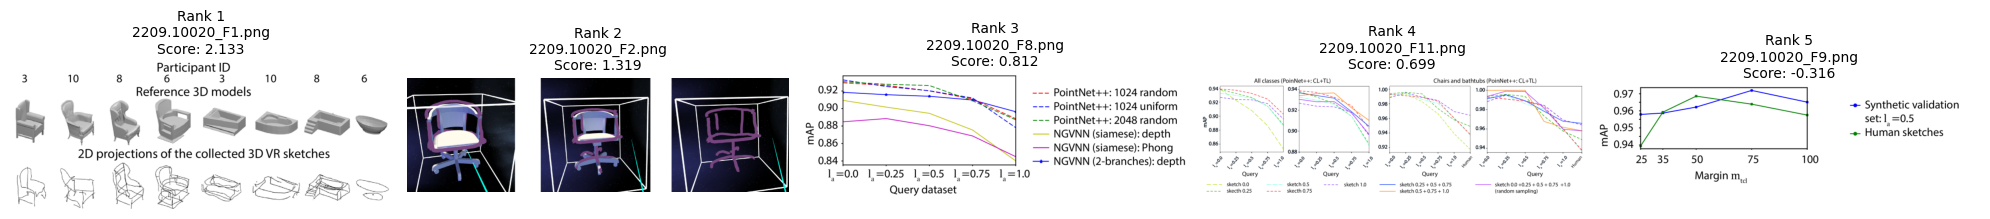

In [112]:
# Retrieve top recommendations
top_k = 5
with torch.inference_mode(), torch.amp.autocast(device.type):
    for _, _, _, _, abstract, figures, captions, label in loader:
        abstract = abstract.to(device)
        figures = figures.to(device)
        captions = captions.to(device) if args.is_merge_caption else None
        label = label.to(device)

        output = model(abstract, figures, captions, label)
        sim = output.sim_abs2fig.cpu()

        probs, preds = sim.sort(dim=-1, descending=True)
        top_scores = probs[0][:top_k]
        top_indices = preds[0][:top_k]

# Display top recommendations
fig, axs = plt.subplots(1, top_indices.size(0), figsize=(top_indices.size(0) * 4, 4))

paths = [sampled_GA_path] + sampled_figure_paths
for j in range(top_indices.size(0)):
    idx = top_indices[j].item()
    score = float(top_scores[j])
    path = paths[idx]
    fig_id = paths[idx].split('/')[-1]

    ax = axs[j]
    if os.path.exists(path):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.set_title(f"Rank {j+1}\n{fig_id}\nScore: {score:.3f}", fontsize=10)
    else:
        ax.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', fontsize=10)

    ax.axis("off")

print(f"Top-{top_k} Intra-GA Figures for Query: arXiv.{sampled_paper_id}")
plt.tight_layout()
plt.show()

# Inter-GA Recommendation

In [ ]:
print("🔧 Setting up environment...")
class InterArgs:
    dataset_json_dir = './SciGA-for-experiments/json/'
    dataset_figure_dir = './SciGA-for-experiments/figures/'
    model_type = 'CLIP'
    ckpt_path = './benchmark/output/checkpoints/inter_with_abs2fig/CLIP_inter_with_abs2fig_cap.pt'
    model_name = None
    model_config_path = None
    device = 0
    batch_size = 8
    num_workers = 2
    is_merge_caption = True

args = InterArgs()
device = torch.device(f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu')
print(f'✅ Using device: {device}')


🔧 Setting up environment...
✅ Using device: cuda:0


In [59]:
print("🔄 Loading datasets...")
train_split = datasets.load_and_prepare_split(
    split_name='train',
    dataset_json_dir=args.dataset_json_dir,
    dataset_figure_dir=args.dataset_figure_dir,
)
test_split = datasets.load_and_prepare_split(
    split_name='test',
    dataset_json_dir=args.dataset_json_dir,
    dataset_figure_dir=args.dataset_figure_dir,
)

print("🔄 Loading model...")
model = model_loader.load_abs2fig_retriever_for_inter_GA_recommendation(
    model_type=args.model_type,
    model_name=args.model_name,
    model_config_path=args.model_config_path,
    ckpt_path=args.ckpt_path,
).to(device)
model.eval()
    
print("✅ Successfully")

🔄 Loading datasets...
🔄 Loading model...
✅ Successfully


In [71]:
print("🔄 Loading dataset...")
sampled = test_split.sample(1).iloc[0]
query_paper_id = sampled['paper_id']
query_abstract = sampled['abstract']
query_GA_caption = sampled['GA_caption']
query_GA_path = sampled['GA_path']
query_research_fields = sampled['research_fields']
query_dataset = datasets.Abs2FigRetrieverDatasetForInterGARecommendation(
    paper_id=[query_paper_id],
    research_fields=[query_research_fields],
    abstract=[query_abstract],
    GA_path=[query_GA_path],
    GA_caption=[query_GA_caption],
    tokenizer=model.tokenize,
    transform=model.preprocess_image,
)

candidate_GA_paths = train_split['GA_path'].tolist()
candidate_dataset = datasets.Abs2FigRetrieverDatasetForInterGARecommendation(
    paper_id=train_split['paper_id'].tolist(),
    research_fields=train_split['research_fields'].tolist(),
    abstract=train_split['abstract'].tolist(),
    GA_path=candidate_GA_paths,
    GA_caption=train_split['GA_caption'].tolist(),
    tokenizer=model.tokenize,
    transform=model.preprocess_image,
)

print("🔄 Loading dataloader...")
query_loader = DataLoader(
    query_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=query_dataset.collate_fn,
    num_workers=args.num_workers,
)

candidate_loader = DataLoader(
    candidate_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    collate_fn=candidate_dataset.collate_fn,
    num_workers=args.num_workers,
)

print("✅ Successfully")

🔄 Loading dataset...
🔄 Loading dataloader...
✅ Successfully


In [61]:
print("🔄 Precomputing GA embeddings from candidate set...")
candidate_embeds = []
with torch.inference_mode(), torch.amp.autocast(device.type):
    for _, _, abstract, GA, caption in tqdm(candidate_loader):
        abstract = abstract.to(device)
        GA = GA.to(device)
        caption = caption.to(device) if args.is_merge_caption else None
        output = model(abstract, GA, caption)
        candidate_embeds.append(output.GA_embed)

candidate_embeds = torch.cat(candidate_embeds, dim=0)
candidate_embeds = candidate_embeds / candidate_embeds.norm(dim=-1, keepdim=True)

print("✅ Successfully")


🔄 Precomputing GA embeddings from candidate set...


100%|██████████| 1792/1792 [03:55<00:00,  7.62it/s]

✅ Successfully


📝 Query Paper Info
   - ID: arXiv.2104.02299
   - Research Fields: ['cs.CV']
   - Abstract: Convolutional neural networks (CNN) have made great progress for synthetic aperture radar (SAR) images change detection. However, sampling locations of traditional convolutional kernels are fixed and cannot be changed according to the actual structure of the SAR images. Besides, objects may appear with different sizes in natural scenes, which requires the network to have stronger multi-scale representation ability. In this paper, a novel Deformable Residual Convolutional Neural Network (DRNet) is designed for SAR images change detection. First, the proposed DRNet introduces the deformable convolutional sampling locations, and the shape of convolutional kernel can be adaptively adjusted according to the actual structure of ground objects. To create the deformable sampling locations, 2-D offsets are calculated for each pixel according to the spatial information of the input images. Then the sampli

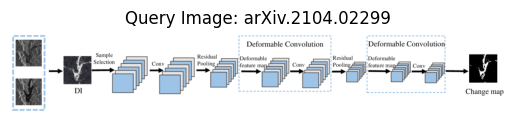

   - Caption: Illustration of the architecture of the DRNet



In [65]:
print("📝 Query Paper Info")
print(f"   - ID: arXiv.{query_paper_id}")
print(f"   - Research Fields: {query_research_fields}")
print(f"   - Abstract: {query_abstract}")

img = mpimg.imread(query_GA_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Query Image: arXiv.{query_paper_id}")
plt.show()

print(f"   - Caption: {query_GA_caption}\n")


Top-5 GA Recommendations for Query: arXiv.2106.12733


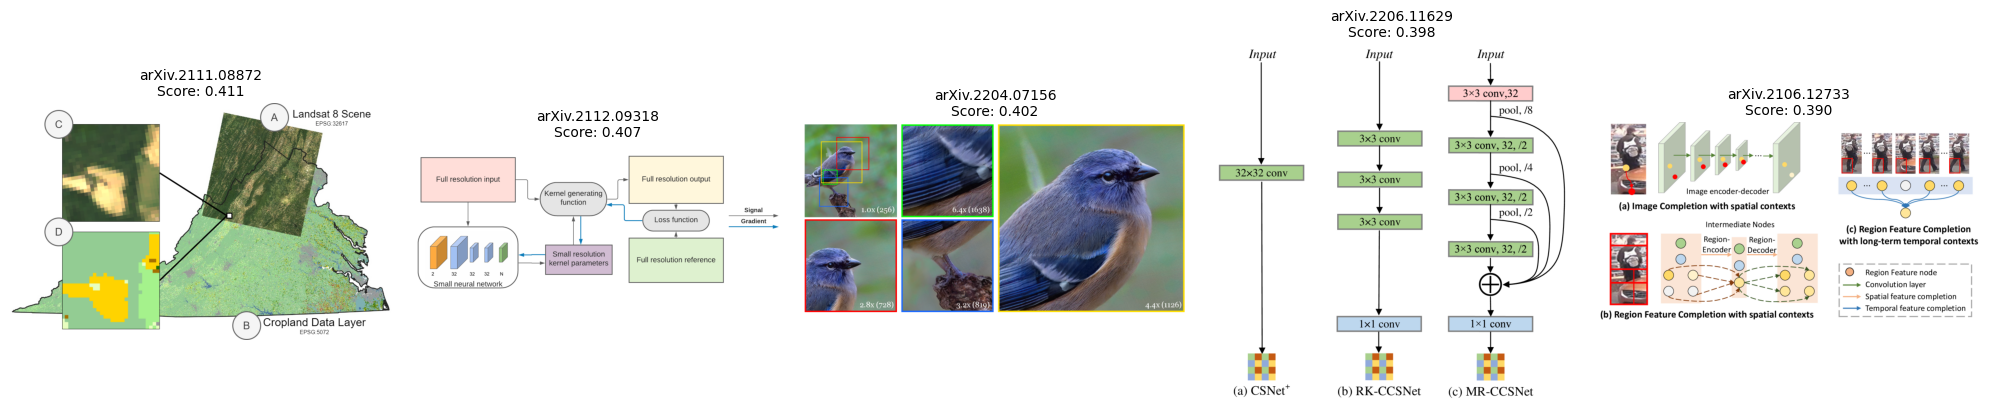

In [66]:
# Retrieve top recommendations
top_k = 5
with torch.inference_mode(), torch.amp.autocast(device.type):
    for _, _, abstract, GA, caption in query_loader:
        abstract = abstract.to(device)
        GA = GA.to(device)
        caption = caption.to(device) if args.is_merge_caption else None

        output = model(abstract, GA, caption)
        query_embed = output.abstract_embed
        query_embed = query_embed / query_embed.norm(dim=-1, keepdim=True)

        sim = torch.matmul(query_embed, candidate_embeds.T)
        top_scores, top_indices = sim.topk(top_k, dim=-1)

# Display top recommendations
fig, axs = plt.subplots(1, top_k, figsize=(top_k * 4, 4))
for j in range(top_k):
    idx = top_indices[0, j].item()
    score = float(top_scores[0, j])
    path = candidate_GA_paths[idx]
    query_paper_id = train_split.iloc[idx]['paper_id']
    query_research_fields = train_split.iloc[idx]['research_fields']

    ax = axs[j]
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.set_title(f"arXiv.{query_paper_id}\nScore: {score:.3f}", fontsize=10)
    ax.axis("off")

print(f"Top-{top_k} GA Recommendations for Query: arXiv.{query_paper_id}")
plt.tight_layout()
plt.show()
